1) Begin by importing libraries and functions for development.

In [29]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler


In [30]:
# Encode categorical variables
from sklearn.impute import KNNImputer
from sklearn.preprocessing import *

# Read the training data
train_df = pd.read_csv('data/train.csv', na_values='')
test_df = pd.read_csv('data/test.csv')
data = pd.concat([train_df, test_df], axis=0)

# label encode the sex
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

# Create title and is_married features
data['Title'] = data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
data['Title'] = data['Title'].apply(len)
data['Is_Married'] = 0
data['Is_Married'].loc[data['Title'] == 'Mrs'] = 1

# Transform names
data['Name'] = data['Name'].apply(len)

# Fill in missing fare information
data['Fare'].fillna(data['Fare'].mean(), inplace=True)

# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
data['Deck'] = data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
data_decks = data.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

# Bin Decks and encode them
idx = data[data['Deck'] == 'T'].index
data.loc[idx, 'Deck'] = 'A'
data['Deck'] = data['Deck'].replace(['A', 'B', 'C'], '3')
data['Deck'] = data['Deck'].replace(['D', 'E'], '2')
data['Deck'] = data['Deck'].replace(['F', 'G'], '1')
data['Deck'] = data['Deck'].replace(['M'], '0')

# one hot encode decks
# data = pd.get_dummies(data, columns=['Deck'], prefix='Deck')

# Note: Label encoding generally works better than one hot for some reason
# label encode the embarked
# S - 1
# Q - 2
# C - 3
data['Embarked'] = data['Embarked'].map({'S': 1, 'Q':2, 'C':3 })
data['Embarked'].fillna(data['Embarked'].median(), inplace=True)
# data = pd.get_dummies(data, columns=['Embarked'], prefix='Embarked')
# data['Embarked_C'].fillna(data['Embarked_C'].median(), inplace=True)
# data['Embarked_Q'].fillna(data['Embarked_Q'].median(), inplace=True)
# data['Embarked_S'].fillna(data['Embarked_S'].median(), inplace=True)

# Drop the cabin column
data = data.drop(columns=['Cabin'])

# copy paste
data['T_partner']=data["SibSp"]+data["Parch"]
data['Alone']=np.where(data['T_partner']>0, 0, 1)
data['is_minor']=np.where(data['Age']<=16,1,0)
data['Ticket_Frequency'] = data.groupby('Ticket')['Ticket'].transform('count')
data['Family_Size'] = data['SibSp'] + data['Parch'] + 1

C:\Users\Quang\AppData\Local\Temp\ipykernel_18700\2697285442.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Is_Married'].loc[data['Title'] == 'Mrs'] = 1


In [31]:
# TICKET STUFF
tickets = True
# if tickets:
# #     # Remove all text from tickets
# #     data['Ticket'] = data['Ticket'].str.replace(r'\D+', '', regex=True)
# #     data['Ticket'] = data['Ticket'].replace('', np.nan)
# #     data['Ticket'] = pd.to_numeric(data['Ticket'], errors='coerce')
# #     data['Ticket'].fillna(data['Ticket'].mean(), inplace=True)
    
# else:
data = data.drop(['Ticket'], axis=1)

# Scale impute ages and rescale
scale = True
if scale:
    # scale data, impute age, then unscale and rescale
    scaler = MinMaxScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
    knn_imputer = KNNImputer(copy=False, n_neighbors=100)
    data_scaled_imputed = knn_imputer.fit_transform(data_scaled)
    data_unscaled_imputed = scaler.inverse_transform(data_scaled_imputed)
    data['Age'] = np.where(data['Age'].isna(), data_unscaled_imputed[:,5], data['Age'])
    data_rescaled = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
else:
    # impute age
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data_rescaled = data

In [32]:
# Train the GradientBoostingClassifer in scikitLearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

# split train and test and drop survived
train = data_rescaled.iloc[train_df.index]
test = data_rescaled[891::].drop("Survived", axis=1)
X = train.drop("Survived", axis=1)
y = train["Survived"]
 ##
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0025, stratify=y, random_state=69420)

param_grid = {'max_depth': range(1,10), 
              'n_estimators': range(1,30),
              'min_samples_split': range(2,10),
              'min_samples_leaf':range(1,10),
              'random_state': [69420]}

grid = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, n_jobs=-1, verbose=1).fit(X_train, y_train)

print('CV Score: {}'.format(grid.best_score_))
print('Test score:', grid.score(X_test, y_test))
print('Best params:\n{}'.format(grid.best_params_))

Fitting 5 folds for each of 18792 candidates, totalling 93960 fits
CV Score: 0.8344505808417445
Test score: 0.6666666666666666
Best params:
{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 28, 'random_state': 69420}


In [33]:
# Fucking Send it
predictions = grid.predict(test).astype(int)
predictions_df = pd.DataFrame({'PassengerId': data[891::]['PassengerId'], 'Survived': predictions})
# predictions_df.to_csv('submission.csv', index=False)

In [34]:
from sklearn.metrics import accuracy_score

# Calculate the score
true = pd.read_csv('data/true.csv').drop(['PassengerId'], axis=1).to_numpy()
pure_pred = predictions_df.drop(['PassengerId'],axis=1).to_numpy()

# This is essentially the Kaggle score.
print(accuracy_score(true, pure_pred))

0.7655502392344498


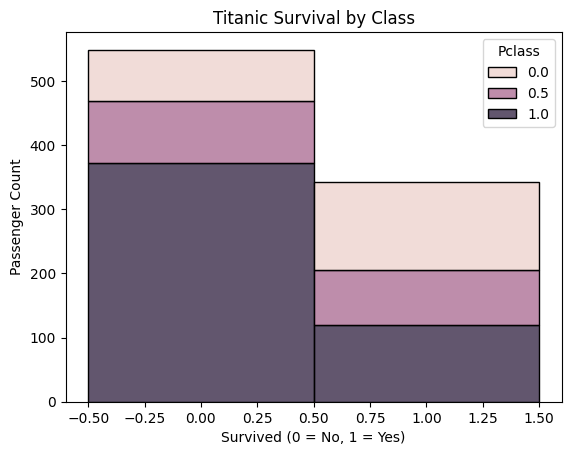

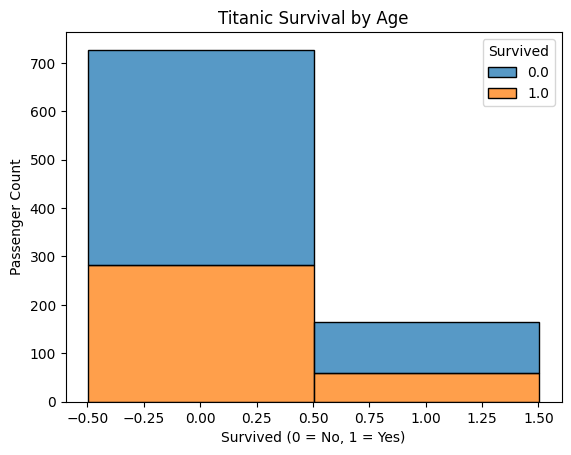

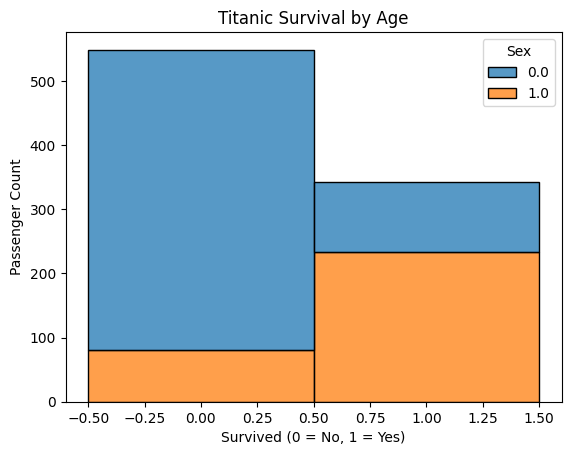

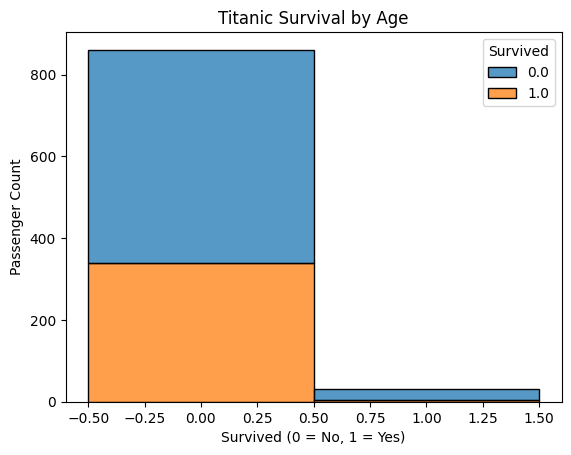

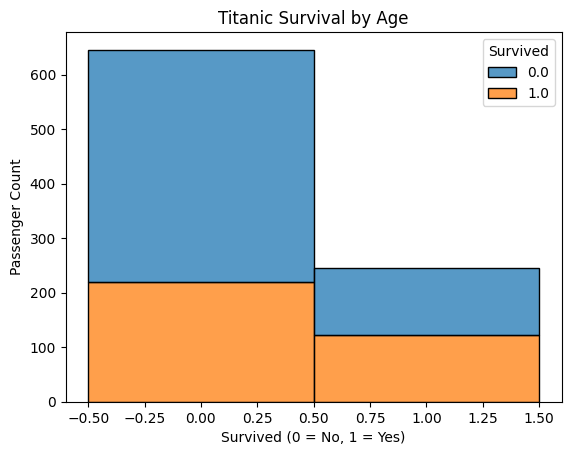

NameError: name 'train_scaled' is not defined

In [35]:
# Visualize stuff

# we need histograms; plot histogram with survived vs not survived,
# segment them by pclass; we can apply this idea to other features too
sns.histplot(data=train, x='Survived', hue='Pclass', multiple='stack', discrete=True)
# Adding labels and title
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Passenger Count')
plt.title('Titanic Survival by Class')
plt.show()

sns.histplot(data=train, x='Age', hue='Survived', multiple='stack', discrete=True)
# Adding labels and title
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Passenger Count')
plt.title('Titanic Survival by Age')
plt.show()

sns.histplot(data=train, x='Survived', hue='Sex', multiple='stack', discrete=True)

# Adding labels and title
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Passenger Count')
plt.title('Titanic Survival by Age')
plt.show()


sns.histplot(data=train, x='SibSp', hue='Survived', multiple='stack', discrete=True)

# Adding labels and title
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Passenger Count')
plt.title('Titanic Survival by Age')
plt.show()

sns.histplot(data=train, x='Embarked', hue='Survived', multiple='stack', discrete=True)

# Adding labels and title
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Passenger Count')
plt.title('Titanic Survival by Age')
plt.show()

sns.histplot(data=train_scaled, x='Ticket', hue='Survived', multiple='stack', discrete=True)

# Adding labels and title
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Passenger Count')
plt.title('Titanic Survival by Age')
plt.show()

# Id is useless, Ticket might be useless
plt.scatter(train['Pclass'], train['Survived'])

# Adding labels and title
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Passenger Count')
plt.title('Titanic Survival by Age')
plt.show()

